# Example: JUSTICE - IAM Simulation Run

In [1]:
import pandas as pd
import numpy as np

from src.util.data_loader import DataLoader
from src.util.enumerations import *
from src.util.model_time import TimeHorizon
from src.model import JUSTICE

/Users/ataberna/opt/anaconda3/envs/coupling/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting Some Dummy Policy Levers

JUSTICE model has two policy levers: Savings rate and Emissions Control Rate. To run the simulation version of the model, we need to feed the policy levers with some values. The range of both savings rate and emissions control rate are from 0 to 1.0 corresponding to 0% to 100%. 

Here we set the savings rate to the intial savings rate data of the different regions and increase it linearly to the optimal savings rate of original DICE/RICE implementation

#### Lever: Fixed Savings rate

Savings rate array can be passed during initialization of JUSTICE. 
If not, fixed savings rate is used. For fixed savings rate, elasticity of marginal utility of consumption and pure rate of time preference is required during init.

In [2]:
#savings_rate = []

#### Lever: Linear Emissions Control Rate

Here the emission control starts at 0, meaning no emission control and increases linearly to 100% emission control rate depending on the transistion start year and the full emission control year.

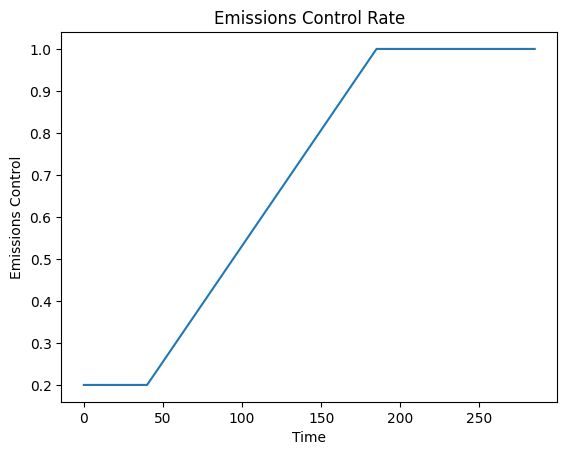

In [3]:
# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.2 #0.0 #1.0
min_miu_year = 2055 #9-original #8 in this model  # 2060
max_miu = 1.0 #1.2
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


from matplotlib import pyplot as plt
plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

## 1. JUSTICE Initialisation

JUSTICE Runs on 8 SSP-RCP scenarios. The SSP-RCP scenarios can be seen with this piece of code

In [4]:
# Get list of Scenarios from Enum

for idx, scenarios in enumerate(list(Scenario.__members__.keys())):
    print(idx, scenarios)

0 SSP119
1 SSP126
2 SSP245
3 SSP370
4 SSP434
5 SSP460
6 SSP534
7 SSP585


Here we initiate the model with a scenario index corresponding to a particular SSP-RCP scenario. The scenario index is from 0 to 7. The scenario index is the same as the index of the SSP-RCP scenarios in the list above.

The initialization phase of JUSTICE loads all the economic and climate data, creates all the arrays to store the results and sets the initial values of the variables.

In [5]:
scenarios = 7
model = JUSTICE(
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.UTILITARIAN,
        # Declaring for endogenous fixed savings rate
        elasticity_of_marginal_utility_of_consumption = 1.45,
        pure_rate_of_social_time_preference = 0.015,
    )

## 2. Run

The run function runs the model for a particular scenario index with the given policy lever setting. The run function returns the results of the simulation.


In [6]:
model.run(emissions_control_rate = emissions_control_rate, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate, 

## 3. Evaluate - SWF - and Generated Output Datasets

Evaluation Phase Extracts the results from the simulation and also applies the social welfare function to compute the welfare

In [5]:
datasets = model.evaluate() #elasticity_of_marginal_utility_of_consumption = 1.45, pure_rate_of_social_time_preference = 0.015, inequality_aversion = 0.5

print(model.get_outcome_names()) # Get the list of outcomes from the simulation run

dict_keys(['net_economic_output', 'consumption', 'consumption_per_capita', 'emissions', 'regional_temperature', 'global_temperature', 'economic_damage', 'abatement_cost', 'carbon_price', 'disentangled_utility', 'welfare_utilitarian_regional_temporal', 'welfare_utilitarian_regional', 'welfare_utilitarian_temporal', 'welfare_utilitarian'])


## 3.1 Stepwise Run & Evaluate

Instead of running the entire model horizon, we can run the model step by step. This is useful for integrating the model with EMODPS framework for adaptive policymaking or RL framework.

In [7]:
from emodps.rbf import RBF
dataset = {}

rbf = RBF(n_rbfs = 4, n_inputs = 2, n_outputs = 57)

c_i, r_i, w_i = rbf.get_rbf_shapes()
# print the shapes of self.centers, self.radii, self.weights
print("self.centers.shape: ", c_i)
print("self.radii.shape: ", r_i)
print("self.weights.shape: ", w_i)

for timestep in range(len(time_horizon.model_time_horizon)):
    
    model.stepwise_run( emissions_control_rate = emissions_control_rate[:, timestep], timestep=timestep, endogenous_savings_rate=True) #savings_rate = fixed_savings_rate[:, timestep],
    datasets = model.stepwise_evaluate(timestep=timestep)
    temp = datasets['global_temperature'][timestep, :] 


    

self.centers.shape:  (8,)
self.radii.shape:  (8,)
self.weights.shape:  (228,)


/Users/ataberna/Documents/JUSTICE/src/welfare/utilitarian.py:158: RuntimeWarning: invalid value encountered in power
  consumption_per_capita_inequality_aversion = np.power(
/Users/ataberna/Documents/JUSTICE/src/welfare/utilitarian.py:158: RuntimeWarning: invalid value encountered in power
  consumption_per_capita_inequality_aversion = np.power(
/Users/ataberna/Documents/JUSTICE/src/welfare/utilitarian.py:158: RuntimeWarning: invalid value encountered in power
  consumption_per_capita_inequality_aversion = np.power(


Extracting the data from the outcome dictionary to the different variables

In [8]:
#Shape of disentangled_utility, disentangled_utility_summed, disentangled_utility_powered, welfare_utilitarian
# Shape of discount_rate
# (57, 286, 1)
#(57, 286, 1001) (286, 1001) (286, 1001) (286, 1001)
#(57, 286, 1001) (286, 1001) (286, 1001) (1001,)
# Shape of discount_rate
# (286, 1)

net_output = datasets['net_economic_output']
consumption = datasets['consumption'] #(57, 286, 1001)
cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)
disentangled_utility = datasets['disentangled_utility'] #(57, 286, 1001)
welfare_utilitarian = datasets['welfare_utilitarian'] # (1001,)
welfare_utilitarian_temporal = datasets['welfare_utilitarian_temporal']  # (286, 1001)
welfare_utilitarian_regional = datasets['welfare_utilitarian_regional'] # (57, 1001)
welfare_utilitarian_regional_temporal = datasets['welfare_utilitarian_regional_temporal'] # (57, 286, 1001)



In [9]:

testdf = welfare_utilitarian_regional_temporal[:, :, 0]


## 4. Visualize

We can visualize the timeseries of the different outcomes that we extracted in the previous step

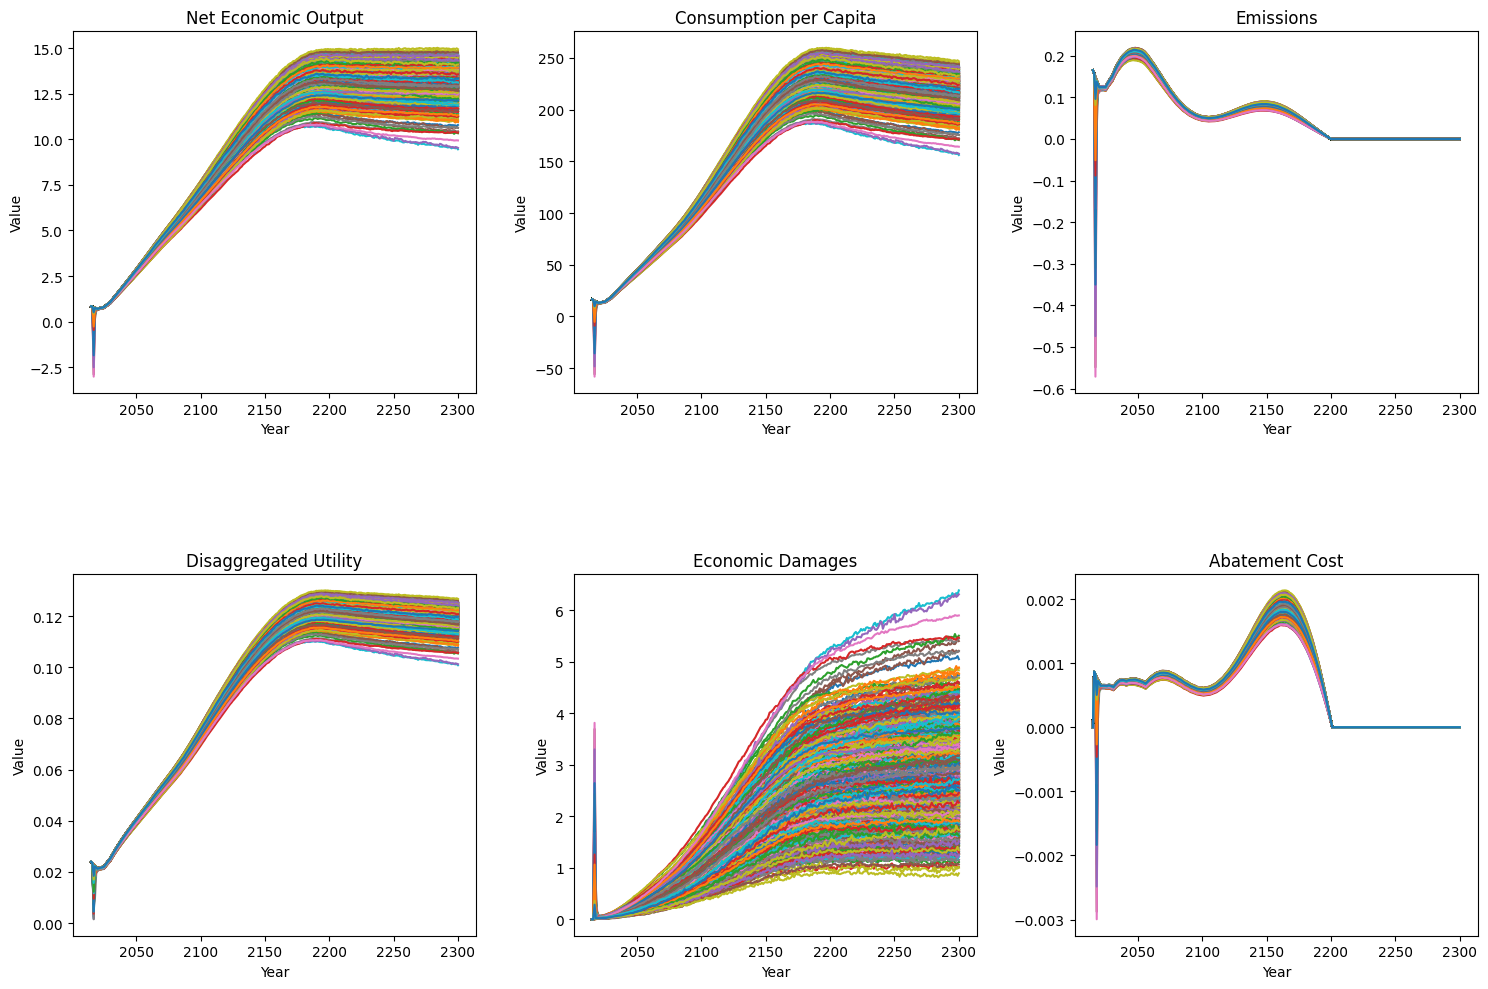

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create list of all the data arrays
data_list = [net_output, cpc, emis, disentangled_utility, damages, abatecost]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Disaggregated Utility', 'Economic Damages', 'Abatement Cost']

region_index = 0

# Create a figure with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, data in enumerate(data_list):
    # Select the region based on region_index
    region_data = data[region_index, :, :]
    
    # Create a line plot for each scenario
    for j in range(region_data.shape[1]):
        sns.lineplot(x=time_horizon.model_time_horizon, y=region_data[:, j], ax=axs[i])
    
    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')
    
# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)





## Run All Scenarios

In [ ]:
# Create a dictionary to store the data for each scenario
scenario_data = {}


for idx, scenarios in enumerate(list(Scenario)):
    print(idx, scenarios)
    
    # Initialize the model
    model = JUSTICE(
        
        start_year = 2015,
        end_year = 2300,
        timestep = 1,
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
    )
    
    # Run the model
    model.run(savings_rate = fixed_savings_rate, emissions_control_rate = emissions_control_rate)

    # elasticity_of_marginal_utility_of_consumption,
    # pure_rate_of_social_time_preference,
    # inequality_aversion,
    # Evaluate the model
    scenario_data[scenarios] = model.evaluate(welfare_function=WelfareFunction.UTILITARIAN)


## The Codes after this point is for testing purpose. Not example codes.

# ______________________________________________________________________________________________________________________

## EMA Workbench Tests

Codes for Uncertainty analysis and Multiobjective optimization

In [12]:
# EMA
from ema_workbench import (
    Model,
    RealParameter,
    ArrayOutcome,
    TimeSeriesOutcome,
    CategoricalParameter,
    ema_logging,
    MultiprocessingEvaluator,
    Constant,
    SequentialEvaluator,
)
from ema_workbench.util.utilities import save_results, load_results

ema_logging.log_to_stderr(ema_logging.INFO)

from src.util.EMA_model_wrapper import model_wrapper_emodps
from src.util.model_time import TimeHorizon
# from src.data_loader import DataLoader

# # Load the data
# data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#Create a fixed savings rate
# fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
#fixed_savings_rate Validated with RICE50 for timestep 1 and 5

model_time_horizon = time_horizon.model_time_horizon

model = Model("JUSTICE", function=model_wrapper_emodps)
model.constants = [
    Constant("n_regions", len(data_loader.REGION_LIST)),
    Constant("n_timesteps", len(time_horizon.model_time_horizon)),
]

# Speicify uncertainties
model.uncertainties = [
    CategoricalParameter(
        "ssp_rcp_scenario", (0, 1, 2, 3, 4, 5, 6, 7)
    ),  # 8 SSP-RCP scenario combinations
    RealParameter("elasticity_of_marginal_utility_of_consumption", 0.0, 2.0),
    RealParameter(
        "pure_rate_of_social_time_preference", 0.0001, 0.020
    ),  # 0.1 to 3% in RICE50 gazzotti2
    RealParameter("inequality_aversion", 0.0, 2.0),  # 0.2 -2.5
]

In [ ]:
from analysis.analyzer import perform_exploratory_analysis

In [ ]:
perform_exploratory_analysis(number_of_experiments=2)

In [ ]:
from ema_workbench import ema_logging, load_results
fn = "./data/output/results_open_exploration_2_95th"
results = load_results(fn)
experiments, outcomes = results

In [ ]:
# experiments.columns
# Select columns of interest ['elasticity_of_marginal_utility_of_consumption', 'inequality_aversion',  'pure_rate_of_social_time_preference', 'ssp_rcp_scenario', 'scenario','policy']
experiments = experiments[['elasticity_of_marginal_utility_of_consumption', 'inequality_aversion',  'pure_rate_of_social_time_preference', 'ssp_rcp_scenario', 'scenario','policy']]

In [ ]:
outcomes.keys()
# global_temperature = outcomes['global_temperature']

In [ ]:
outcomes_array = outcomes['disentangled_utility']

# compute the mean across the scenarios
mean_arr = np.mean(outcomes_array, axis=0)

# let's define n as the amount of close scenarios you'd like to select
n = 10

# compute the difference between each scenario and the mean
diff = outcomes_array - mean_arr

# compute the "distance" to the mean
distances = np.linalg.norm(diff, axis=(1,2))

# get the indices of the n scenarios with smallest distances
# here, np.argsort returns the indices that would sort the distances
# we are interested in the first n of these (the ones with smallest distance)
closest_indices = np.argsort(distances)[:n]

print(f"The scenarios that are closest to the mean are at indices {closest_indices} out of 2000.")

# # compute the difference between each scenario and the mean
# diff = outcomes_array - mean_arr

# # Now we want to compute the "distance" to the mean, we can use Euclidean distance as a measure
# distances = np.linalg.norm(diff, axis=(1,2))

# # the scenario that represents the mean is the one with the smallest distance
# index = np.argmin(distances)

# print(f"The scenario that represents the mean is at index {index} out of 2000.")

# # sum the utility for all regions
# # outcomes_array = np.sum(outcomes_array, axis=1)
# # mean_util = np.mean(outcomes_array, axis=0)
# median_util = np.median(outcomes_array, axis=0)
# #95th percentile
# p95_util = np.percentile(outcomes_array, 95, axis=0)
# #5th percentile
# p5_util = np.percentile(outcomes_array, 5, axis=0)

# # Sum the utility for all regions
# mean_util = np.sum(mean_util, axis=0)
# median_util = np.sum(median_util, axis=0)
# #95th percentile
# p95_util = np.sum(p95_util, axis=0)
# #5th percentile
# p5_util = np.sum(p5_util, axis=0)


# Plot the mean, median, 5th and 95th percentile. Array is of shape (57, 286). 286 are the timesteps. 57 are the scenarios
# plt.plot(mean_util, label='Mean')
# plt.plot(median_util, label='Median')
# plt.plot(p95_util, label='95th Percentile')
# plt.plot(p5_util, label='5th Percentile')
# plt.xlabel('Time')
# plt.ylabel('Utility')
# plt.title('Utility over Time')
# plt.legend()
# plt.show()


In [ ]:
# Load the data
from src.data_loader import DataLoader
import pandas as pd
data_loader = DataLoader()

region_list = data_loader.REGION_LIST
region_list[54] # US
region_list[43] #Sub saharan 


## Main Analysis Starts Here

In [ ]:
# Load the combined arrays
import pickle
import numpy as np
with open('./data/output/temp_combined_1000.pkl', 'rb') as f:
    combined_temp = pickle.load(f)
with open('./data/output/damages_combined_1000.pkl', 'rb') as f:
    combined_damages = pickle.load(f)
with open('./data/output/dis_util_combined_1000.pkl', 'rb') as f:
    combined_dis_util = pickle.load(f)
with open('./data/output/experiments_combined_1000.pkl', 'rb') as f:
    combined_experiments = pickle.load(f)

# Load welfare_utilitarian_regional_combined_1000
with open('./data/output/welfare_utilitarian_regional_combined_1000.pkl', 'rb') as f:
    welfare_utilitarian_regional_combined_1000 = pickle.load(f)
    welfare_utilitarian_regional_combined_1000 = welfare_utilitarian_regional_combined_1000.T

# Load welfare_utilitarian_combined_1000
with open('./data/output/welfare_utilitarian_combined_1000.pkl', 'rb') as f:
    welfare_utilitarian_combined_1000 = pickle.load(f)
    



In [ ]:
import numpy as np
# Load the data
temperature_array = np.load("./data/output/temperature_array.npy", allow_pickle=True)
data_array = np.load("./data/output/damages_array.npy", allow_pickle=True)
disentangled_utility = np.load("./data/output/disentangled_utility.npy", allow_pickle=True)
experiment_array = np.load("./data/output/experiment_array.npy", allow_pickle=True)

In [ ]:
# Load the data in input/solved_RICE50_data folder
import pandas as pd
import numpy as np


solved_damages = np.load("./data/input/solved_RICE50_data/solved_damages.npy", allow_pickle=True)
solved_emissions_control = np.load("./data/input/solved_RICE50_data/solved_emissions_control.npy", allow_pickle=True)
solved_savings_rate = np.load("./data/input/solved_RICE50_data/solved_savings_rate.npy", allow_pickle=True)
solved_TATM = np.load("./data/input/solved_RICE50_data/solved_TATM.npy", allow_pickle=True)


In [ ]:
from src.model_time import TimeHorizon

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
from analysis.output_data_processor import interpolator


interpolated_emissions_control = interpolator(solved_emissions_control, time_horizon.data_time_horizon, time_horizon.model_time_horizon)
interpolated_savings_rate = interpolator(solved_savings_rate, time_horizon.data_time_horizon, time_horizon.model_time_horizon)
interpolated_TATM = interpolator(solved_TATM, time_horizon.data_time_horizon, time_horizon.model_time_horizon)
interpolated_damages = interpolator(solved_damages, time_horizon.data_time_horizon, time_horizon.model_time_horizon)



In [ ]:
# Save interpolated emissions control rate and interpolated savings rate as npy

np.save('./data/input/solved_RICE50_data/interpolated_emissions_control.npy', interpolated_emissions_control)
np.save('./data/input/solved_RICE50_data/interpolated_savings_rate.npy', interpolated_savings_rate)
np.save('./data/input/solved_RICE50_data/RICE50_interpolated_TATM.npy', interpolated_TATM)
np.save('./data/input/solved_RICE50_data/RICE50_interpolated_damages.npy', interpolated_damages)


### Visualization Code Development

In [ ]:
import numpy as np
# Load interpolated damages
interpolated_damages = np.load("./data/input/solved_RICE50_data/RICE50_interpolated_damages.npy", allow_pickle=True) # Shape (5, 57, 286)
# Load damages array
damages_array = np.load("./data/output/damages_array.npy", allow_pickle=True) # Shape (8000, 57, 286)

# Load the TATM interpolated
interpolated_TATM = np.load("./data/input/solved_RICE50_data/RICE50_interpolated_TATM.npy", allow_pickle=True) # Shape (5, 286)
# Load temperature array
temperature_array = np.load("./data/output/temperature_array.npy", allow_pickle=True) # Shape (8000, 286)

# Load experiment array
experiment_array = np.load("./data/output/experiment_array.npy", allow_pickle=True) # Shape (8000, 4)

In [ ]:
#convert experiment array to dataframe and add column names
import pandas as pd
experiment_array = pd.DataFrame(experiment_array, columns=
            [
                "elasticity_of_marginal_utility_of_consumption",
                "inequality_aversion",
                "pure_rate_of_social_time_preference",
                "ssp_rcp_scenario",
                "scenario",
                "policy",
            ]
        )

In [ ]:
from src.enumerations import get_economic_scenario


import pandas as pd
import numpy as np
#Select the temperature array scenario from index from 4000-6000
mean_temperature_array = temperature_array #temperature_array[4000:6000, :]
mean_experiment_array = experiment_array #experiment_array.iloc[4000:6000, :]

#Reset index
# mean_temperature_array = pd.DataFrame(mean_temperature_array).reset_index(drop=True)
# mean_experiment_array = mean_experiment_array.reset_index(drop=True)

# Assuming experiment_array and temperature_array here are represented as DataFrame and np.ndarray.

scenario_indexes = []
# get the indexes of rows for all the scenarios from 0 to 7
for x in range(8):
    scenario_indexes.append(
        mean_experiment_array[mean_experiment_array['ssp_rcp_scenario'] == x].index.tolist()
    )

# Assume your temperature array is a numpy ndarray
# Filter out temperature array using the list of indexes
temperature_array_sorted = {}

for i, indexes in enumerate(scenario_indexes):
    temperature_array_sorted[i] = np.array([mean_temperature_array[j] for j in indexes])

# Use scenario_indexes to filter out experiment_array
experiment_array_sorted = {}

for i, indexes in enumerate(scenario_indexes):
    experiment_array_sorted[i] = mean_experiment_array.loc[indexes]

In [ ]:
# Sort damages_array

#damages_array_summed = np.sum(damages_array, axis=1)

damages_array_sorted = {}

for i, indexes in enumerate(scenario_indexes):
    damages_array_sorted[i] = np.array([damages_array[j] for j in indexes])



In [ ]:
df = experiment_array_sorted[1]

In [ ]:
# Plot temperature array for each scenario
import matplotlib.pyplot as plt
for i in range(8):
    plt.plot(temperature_array_sorted[i].mean(axis=0), label=get_economic_scenario(i))

In [ ]:
print(get_economic_scenario(7))
# Use list of years as column labels for the combined_temp array
#temperature_array = pd.DataFrame(temperature_array, columns=list_of_years)

# df = pd.DataFrame(temperature_array)
# df = df.T
# for i in range(len(df.columns)):
    
#     sns.lineplot(data=df.iloc[:,i],palette="tab10", linewidth=0.5, alpha=0.5)
# sns.lineplot(data=df.iloc[:,0])
# plt.title("Temperature Array")
# plt.xlabel("Time")
# plt.ylabel("Temperature")
# plt.show()

    #plt.plot(rice50_temp.iloc[i, :], label=f'SSP {i+1}')

# Label the percentiles
# plt.text(2300, 0.5, '0th percentile', color='black')
# plt.text(2300, 2.5, '5th percentile', color='black')
# plt.text(2300, 3.5, '25th percentile', color='black')
# plt.text(2300, 4.5, '75th percentile', color='black')
# plt.text(2300, 5.5, '95th percentile', color='black')
# plt.text(2300, 11.5, '100th percentile', color='black')

In [ ]:
# empty dictionary to hold temperature arrays separated by SSPs
temperature_array_sorted_by_ssp = {0: [], 1: [], 2: [], 3: [], 4: []}

# iterate over temperature_array_sorted dictionary
for scenario in temperature_array_sorted:
    # get the corresponding SSP for scenario
    ssp = get_economic_scenario(scenario)
    # append the temperature array for scenario to the appropriate SSP key in temperature_array_sorted_by_ssp
    temperature_array_sorted_by_ssp[ssp].extend(temperature_array_sorted[scenario])

# converting lists in the dictionary to numpy arrays
for ssp in temperature_array_sorted_by_ssp:
    temperature_array_sorted_by_ssp[ssp] = np.array(temperature_array_sorted_by_ssp[ssp])

In [ ]:
# Plot the mean of ssps in temperature_array_sorted_by_ssp
for ssp in temperature_array_sorted_by_ssp:
    plt.plot(np.mean(temperature_array_sorted_by_ssp[ssp], axis=0), label=f'SSP {ssp}')



In [ ]:
# Plot temperature array dataframe of shape (8000, 286) where 8000 are the scenarios and 286 are the timesteps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.model_time import TimeHorizon


time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
list_of_years = time_horizon.model_time_horizon

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("white")
#plt.figure(figsize=(15, 8))
last_idx = -1
# colors = ['blue', 'green', 'yellow', 'red', 'violet']
colors = ['red', 'orange', 'green', 'blue', 'indigo']

fig, ax = plt.subplots(figsize=(15, 8))

rice50_temp = pd.DataFrame(interpolated_TATM, columns=list_of_years)

# Loop through each ssp in your sorted data
for i in range(8):
    # calculate 5th and 95th percentiles
    p_5 = np.percentile(temperature_array_sorted[i], 5, axis=0)
    p_95 = np.percentile(temperature_array_sorted[i], 95, axis=0)

    idx = get_economic_scenario(i)
    
    # Plot percentiles as bands
    ax.fill_between(list_of_years, p_5, p_95, color=colors[idx], alpha=0) #.2

    
    # Plot the interpolated TATM for each scenario
    if last_idx != idx:
        sns.lineplot(data=rice50_temp.iloc[idx, :], color=colors[idx], label=f'SSP {idx+1}', ax=ax)

    last_idx = idx


# Access the current Axes instance on the current figure:
ax = plt.gca()

# Remove top and right border
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
  
# Remove top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels, legend and title
plt.xlabel('Year')
plt.ylabel('Temperature Rise')
plt.legend(loc='upper left')

plt.show()

In [ ]:
from src.enumerations import get_economic_scenario, Scenario
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from src.model_time import TimeHorizon



ssp_rcp_string_list = ["SSP1-RCP1.9", "SSP1-RCP2.6", "SSP2-RCP4.5", "SSP3-RCP7.0", "SSP4-RCP3.4", "SSP4-RCP6.0", "SSP5-RCP3.4-overshoot", "SSP5-RCP8.5"]

scenario = list(Scenario)
# Color Mapping
colors = ['red', 'orange', 'green', 'blue', 'indigo']

# Time Horizon Setup
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
list_of_years = time_horizon.model_time_horizon

rice50_temp = pd.DataFrame(interpolated_TATM, columns=list_of_years)

# Create subplots in grid of 4 rows and 2 columns
fig, axs = plt.subplots(2, 4, figsize=(25, 12))

# Reshape axs to 1D for easy iteration
axs = axs.ravel()

# find overall min and max temperatures (5th and 95th percentile respectively) amongst all data
global_min = np.min([np.percentile(temperature_array_sorted[i], 5, axis=0) for i in range(8)])
global_max = np.max([np.percentile(temperature_array_sorted[i], 95, axis=0) for i in range(8)])

for i in range(8):
    # calculate 5th and 95th percentiles
    p_5 = np.percentile(temperature_array_sorted[i], 5, axis=0)
    p_95 = np.percentile(temperature_array_sorted[i], 95, axis=0)

    # Get the economic scenario corresponding to the index
    idx = get_economic_scenario(i)

    # Plot percentiles as bands
    axs[i].fill_between(list_of_years, p_5, p_95, color=colors[idx], alpha=0.2)


    # Plot
    sns.lineplot(data=rice50_temp.iloc[idx, :], color=colors[idx], ax=axs[i])

    # Styling each subplot
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].xaxis.set_ticks_position('bottom')
    axs[i].yaxis.set_ticks_position('left')

    # axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Temperature Rise')
    axs[i].legend([f'SSP {idx+1}'], loc='upper left')
    # Set title for each subplot
    axs[i].set_title(ssp_rcp_string_list[i]) #(scenario[i].value[2])
    axs[i].title.set_size(20)
    axs[i].set_ylim(global_min, global_max)

plt.tight_layout()
plt.show()


In [ ]:
from src.enumerations import get_economic_scenario, Scenario
scenario = list(Scenario)
scenario[0].value[2]

In [ ]:
# Plot temperature array dataframe of shape (8000, 286) where 8000 are the scenarios and 286 are the timesteps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.model_time import TimeHorizon

time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
list_of_years = time_horizon.model_time_horizon


# Setting style and size
sns.set_style("white")
plt.figure(figsize=(15, 8))

# Calculate percentiles and median
p_0 = np.percentile(temperature_array, 0, axis=0)
p_5 = np.percentile(temperature_array, 5, axis=0)
p_25 = np.percentile(temperature_array, 25, axis=0)
p_75 = np.percentile(temperature_array, 75, axis=0)
p_95 = np.percentile(temperature_array, 95, axis=0)
p_100 = np.percentile(temperature_array, 100, axis=0)
median = np.median(temperature_array, axis=0)

# Plot percentiles as bands
plt.fill_between(temperature_array.columns, p_0, p_100, color='red', alpha=0.3)
plt.fill_between(temperature_array.columns, p_5, p_95, color='red', alpha=0.2)
plt.fill_between(temperature_array.columns, p_25, p_75, color='red', alpha=0.4)

# Plot median
plt.plot(temperature_array.columns, median, color='red')

# Use the list of years as x-axis and the interpolated TATM for each scenario as y-axis
rice50_temp = pd.DataFrame(interpolated_TATM, columns=list_of_years)
# Overlay the interpolated TATM for all 5 scenarios. TATM shape (5, 286) Each scenario with a different color and with legend
for i in range(rice50_temp.shape[0]):
    # Use a list of colors
    colors = ['blue', 'green', 'black', 'purple', 'brown']
    sns.lineplot(data=rice50_temp.iloc[i, :], color=colors[i], label=f'SSP {i+1}')




# Access the current Axes instance on the current figure:
ax = plt.gca()

# Remove top and right border
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
  
# Remove top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Temperature Rise')

# Add legend
plt.legend(loc='upper left')

# plt.title('Time series plot of Atmospheric Temperature Rise')

plt.show()

In [ ]:
# Same for damages array
# Setting style and size
sns.set_style("white")
plt.figure(figsize=(15, 8))

damages_array_summed = np.sum(damages_array, axis=1)
damages_array_summed = pd.DataFrame(damages_array_summed, columns=list_of_years)


# Calculate percentiles and median
p_0 = np.min(damages_array_summed, axis=0)
#p_0 = np.percentile(damages_array_summed, 0, axis=0)
# p_5 = np.percentile(damages_array_summed, 5, axis=0)
# p_25 = np.percentile(damages_array_summed, 25, axis=0)
# p_75 = np.percentile(damages_array_summed, 75, axis=0)
# p_95 = np.percentile(damages_array_summed, 95, axis=0)
p_100 = np.max(damages_array_summed, axis=0)
#p_100 = np.percentile(damages_array_summed, 100, axis=0)
median = np.median(damages_array_summed, axis=0)

# Plot percentiles as bands
plt.fill_between(damages_array_summed.columns, p_0, p_100, color='green', alpha=0.3)
# plt.fill_between(damages_array_summed.columns, p_5, p_95, color='green', alpha=0.2)
# plt.fill_between(damages_array_summed.columns, p_25, p_75, color='green', alpha=0.4)

# Plot median
plt.plot(damages_array_summed.columns, median, color='green')

# Sum the damages for all regions
rice50_damages = np.sum(interpolated_damages, axis=1)
# Use the list of years as x-axis and the interpolated damages for each scenario as y-axis
rice50_damages = pd.DataFrame(rice50_damages, columns=list_of_years)


# Overlay the interpolated damages for all 5 scenarios. Damages shape (5, 286) Each scenario with a different color and with legend
for i in range(rice50_damages.shape[0]):
    # Use a list of colors
    colors = ['blue', 'red', 'black', 'purple', 'brown']
    sns.lineplot(data=rice50_damages.iloc[i, :], color=colors[i], label=f'SSP {i+1}')

# Access the current Axes instance on the current figure:
ax = plt.gca()

# Remove top and right border
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
  
# Remove top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Economic Damage')

# Add legend
plt.legend(loc='upper left')

# plt.title('Time series plot of Atmospheric Temperature Rise')

plt.show()






In [ ]:
# Plot temperature array dataframe of shape (8000, 286) where 8000 are the scenarios and 286 are the timesteps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.model_time import TimeHorizon


time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
list_of_years = time_horizon.model_time_horizon

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("white")
#plt.figure(figsize=(15, 8))
last_idx = -1
# colors = ['blue', 'green', 'yellow', 'red', 'violet']
colors = ['red', 'orange', 'green', 'blue', 'indigo']

fig, ax = plt.subplots(figsize=(15, 8))

#rice50_temp = pd.DataFrame(interpolated_TATM, columns=list_of_years)
rice50_damages = np.sum(interpolated_damages, axis=1)
# Use the list of years as x-axis and the interpolated damages for each scenario as y-axis
rice50_damages = pd.DataFrame(rice50_damages, columns=list_of_years)

# Loop through each ssp in your sorted data
for i in range(8):
    # calculate 5th and 95th percentiles
    p_5 = np.percentile(np.sum(damages_array_sorted[i], axis=1), 5, axis=0)
    p_95 = np.percentile(np.sum(damages_array_sorted[i], axis=1), 95, axis=0)

    idx = get_economic_scenario(i)
    
    # Plot percentiles as bands
    ax.fill_between(list_of_years, p_5, p_95, color=colors[idx], alpha=0.2)

    
    # Plot the interpolated TATM for each scenario
    if last_idx != idx:
        sns.lineplot(data=rice50_damages.iloc[idx, :], color=colors[idx], label=f'SSP {idx+1}', ax=ax)

    last_idx = idx


# Access the current Axes instance on the current figure:
ax = plt.gca()

# Remove top and right border
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
  
# Remove top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Add labels, legend and title
plt.xlabel('Year')
plt.ylabel('Economic Damage Trillion $')
plt.legend(loc='upper left')

plt.show()

In [ ]:
from src.enumerations import get_economic_scenario, Scenario
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from src.model_time import TimeHorizon



ssp_rcp_string_list = ["SSP1-RCP1.9", "SSP1-RCP2.6", "SSP2-RCP4.5", "SSP3-RCP7.0", "SSP4-RCP3.4", "SSP4-RCP6.0", "SSP5-RCP3.4-overshoot", "SSP5-RCP8.5"]

scenario = list(Scenario)
# Color Mapping
colors = ['red', 'orange', 'green', 'blue', 'indigo']

# Time Horizon Setup
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
list_of_years = time_horizon.model_time_horizon

# rice50_temp = pd.DataFrame(interpolated_TATM, columns=list_of_years)
# damages_array_summed = np.sum(damages_array, axis=1)
# damages_array_summed = pd.DataFrame(damages_array_summed, columns=list_of_years)
# Sum the damages for all regions
rice50_damages = np.sum(interpolated_damages, axis=1)
# Use the list of years as x-axis and the interpolated damages for each scenario as y-axis
rice50_damages = pd.DataFrame(rice50_damages, columns=list_of_years)

# Create subplots in grid of 4 rows and 2 columns
fig, axs = plt.subplots(2, 4, figsize=(25, 12))

# Reshape axs to 1D for easy iteration
axs = axs.ravel()

# find overall min and max temperatures (5th and 95th percentile respectively) amongst all data
global_min = np.min([np.percentile(np.sum(damages_array_sorted[i], axis=1), 5, axis=0) for i in range(8)])
global_max = np.max([np.percentile(np.sum(damages_array_sorted[i], axis=1), 95, axis=0) for i in range(8)])

for i in range(8):
    # calculate 5th and 95th percentiles
    p_5 = np.percentile(np.sum(damages_array_sorted[i], axis=1), 5, axis=0)
    p_95 = np.percentile(np.sum(damages_array_sorted[i], axis=1), 95, axis=0)

    # Get the economic scenario corresponding to the index
    idx = get_economic_scenario(i)

    # Plot percentiles as bands
    axs[i].fill_between(list_of_years, p_5, p_95, color=colors[idx], alpha=0.2)


    # Plot
    sns.lineplot(data=rice50_damages.iloc[idx, :], color=colors[idx], ax=axs[i])

    # Styling each subplot
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].xaxis.set_ticks_position('bottom')
    axs[i].yaxis.set_ticks_position('left')

    # axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Economic Damages Trillion $')
    axs[i].legend([f'SSP {idx+1}'], loc='upper left')
    # Set title for each subplot
    axs[i].set_title(ssp_rcp_string_list[i]) #(scenario[i].value[2])
    # Set title font size
    axs[i].title.set_size(20)

    axs[i].set_ylim(global_min, global_max)

plt.tight_layout()
plt.show()


In [ ]:
from analysis.output_data_processor import calculate_welfare

from src.model_time import TimeHorizon

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

timestep_list = np.arange(
    0, len(time_horizon.model_time_horizon), time_horizon.timestep
)

welfare_utilitarian = np.zeros((experiment_array.shape[0]))
welfare_utilitarian_regional = np.zeros((57, experiment_array.shape[0]))

for i in range(experiment_array.shape[0]):

    welfare_utilitarian_regional[:,i], welfare_utilitarian[i] = calculate_welfare(experiment_array[i], disentangled_utility[i], time_horizon)

## Feature Scores

In [ ]:
from src.model_time import TimeHorizon
from analysis.output_data_processor import calculate_welfare

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

# Convert experiments_array dataframe to numpy array
# experiments = experiment_array #np.array(experiment_array)

welfare_utilitarian = np.zeros((experiment_array.shape[0]))
welfare_utilitarian_regional = np.zeros((57, experiment_array.shape[0]))

for i in range(experiment_array.shape[0]):

    welfare_utilitarian_regional[:,i], welfare_utilitarian[i] = calculate_welfare(experiment_array[i], disentangled_utility[i], time_horizon)



In [ ]:
#Plot welfare_utilitarian of shape (60000, )
import seaborn as sns
import matplotlib.pyplot as plt

#Plot distribution of welfare_utilitarian

sns.set_style("white")
plt.figure(figsize=(15, 8))

# Plot distribution of welfare_utilitarian

sns.histplot(welfare_utilitarian, kde=True, bins=100, color='red')
plt.xlabel('Welfare Utilitarian')
plt.ylabel('Frequency')
plt.title('Distribution of Welfare Utilitarian')

plt.show()






In [ ]:
# Load the data
from src.data_loader import DataLoader
import pandas as pd
data_loader = DataLoader()

region_list = data_loader.REGION_LIST

# Convert region list to a dataframe
region_list = pd.DataFrame(region_list)
#region_list.iloc[54] # US
# region_list[54] # US
# region_list[43] #Sub saharan 
region_list[0].values

# Get the list of regions as byte strings
regions_byte = region_list[0].values

# Decode byte strings to normal strings
regions_str = [region.decode('utf-8') for region in regions_byte]

In [ ]:
# Need to drop the nan and inf values from the welfare_utilitarian array

regional_welfare = welfare_utilitarian_regional.T

# filtered_index = filtered_df.dropna()
# filtered_index = filtered_index.index

# filtered_experiments = combined_experiments[filtered_index]

import numpy as np
import pandas as pd

# Identify the indices where nan or inf values present
indices = np.where(np.isnan(regional_welfare) | np.isinf(regional_welfare) | (regional_welfare<-100000) | (regional_welfare>100000))

# Get the unique row indices
unique_row_indices = np.unique(indices[0])

# Drop those rows from the array
regional_welfare = np.delete(regional_welfare, unique_row_indices, axis=0)

# Assuming `experiments_df` is your DataFrame, drop the corresponding rows from the DataFrame
experiments_df = experiment_array.drop(unique_row_indices)

print(regional_welfare.shape)
print(experiments_df.shape)

In [ ]:
# Filter welfare_utilitarian for values between -100000 and 100000 and nan and inf values

global_welfare = welfare_utilitarian

# Identify the indices where nan or inf values present
indices = np.where(np.isnan(global_welfare) | np.isinf(global_welfare) | (global_welfare<-100000) | (global_welfare>100000))

# Get the unique row indices
unique_row_indices = np.unique(indices[0])

# Drop those rows from the array
global_welfare = np.delete(global_welfare, unique_row_indices, axis=0)

# Assuming `experiments_df` is your DataFrame, drop the corresponding rows from the DataFrame
experiments_df = experiment_array.drop(unique_row_indices)

print(global_welfare.shape)
print(experiments_df.shape)

In [ ]:
# region_idx = 43
import warnings
warnings.filterwarnings('ignore')

filtered_outcomes = {}
from ema_workbench.analysis import feature_scoring
# Create a empty dataframe to store the feature scores of shape 57, 3
scores = pd.DataFrame(np.zeros((57, 4)), columns=['elasticity_of_marginal_utility_of_consumption', 'inequality_aversion', 'pure_rate_of_social_time_preference', 'ssp_rcp_scenario'])
# Loop throught he regions_str list

for region_idx in range(57):
    print(region_idx)
    # Create a dictionary to store the filtered outcomes
    filtered_outcomes[regions_str[region_idx]] = regional_welfare[:,region_idx]
    filtered_outcomes[regions_str[region_idx]] = regional_welfare[:,region_idx]
    # Suppress the warnings


    scores = feature_scoring.get_feature_scores_all(experiments_df.iloc[:, :4], filtered_outcomes)
    
sns.heatmap(scores, annot=True, cmap='viridis')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

filtered_outcomes_global = {}   

from ema_workbench.analysis import feature_scoring
# Create a empty dataframe to store the feature scores of shape 57, 3
global_scores = pd.DataFrame(np.zeros((57, 4)), columns=['elasticity_of_marginal_utility_of_consumption', 'inequality_aversion', 'pure_rate_of_social_time_preference', 'ssp_rcp_scenario'])

filtered_outcomes_global['Global'] = global_welfare

global_scores = feature_scoring.get_feature_scores_all(experiments_df.iloc[:, :4], filtered_outcomes_global)


In [ ]:
# Save the scores as npy
np.save('./data/output/feature_scores_60k_4outcomes.npy', scores)

In [ ]:
# Save global scores as npy
np.save('./data/output/global_feature_scores_60k_4outcomes.npy', global_scores)

In [ ]:
scores_global = global_scores.T
# Rename the columns
scores_global.columns = ['Elasticity of Marginal Utility of Consumption', 'Inequality Aversion', 'Pure rate of Social Time Preference', 'SSP RCP Scenario']
#Rearrange the columns pure rate of social time preference, inequality aversion, elasticity of marginal utility of consumption
scores_global = scores_global[['SSP RCP Scenario', 'Pure rate of Social Time Preference', 'Inequality Aversion', 'Elasticity of Marginal Utility of Consumption']]

# Set up figure size to be as square as possible
fig, ax = plt.subplots(figsize=(15,15))

# Create a heatmap without annotations
 
sns.heatmap(scores_global, annot=True, cmap='flare', ax=ax)
plt.show()

In [ ]:
processed_scores = scores.T
#Drop the first row
# processed_scores = processed_scores.iloc[1:]
# Rename the columns
processed_scores.columns = ['Elasticity of Marginal Utility of Consumption', 'Inequality Aversion', 'Pure rate of Social Time Preference','SSP RCP Scenario']

# Rearrange the columns - pure rate of social time preference, inequality aversion, elasticity of marginal utility of consumption
processed_scores = processed_scores[['SSP RCP Scenario', 'Pure rate of Social Time Preference', 'Inequality Aversion', 'Elasticity of Marginal Utility of Consumption']]



import seaborn as sns
import matplotlib.pyplot as plt

# assuming 'df' is your DataFrame

# Set up figure size to be as square as possible
fig, ax = plt.subplots(figsize=(15,15))

# Create a heatmap without annotations
sns.heatmap(processed_scores, cmap="flare",  annot=False, ax=ax) #square=True,
# Rotate x-axis labels
plt.xticks(rotation=0)

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# assuming 'df' is your DataFrame

# Melt your DataFrame to make it suitable for Seaborn's boxplot function
processed_scores_df_melted = processed_scores.melt()

# Set color palette to match with Heatmap
palette = sns.color_palette("flare", as_cmap=True)

# Create a figure and set its size
plt.figure(figsize=(12, 8))

# Create a boxplot
sns.boxplot(x='variable', y='value', data=processed_scores_df_melted, palette="flare").set_title('Boxplot for Parameters')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Remove the box around the plot
sns.despine()

# Show the plot
plt.show()

In [ ]:
# Damages at 2300 and welfare 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


damage_array = combined_damages[:, :, 285] #285 -2300 # 85 - 2100

# Convert the numpy array to a pandas dataframe, use region names
damage_df = pd.DataFrame(damage_array, columns = regions_str)

# Convert dataframe to long-form
damage_df_long = damage_df.melt(var_name='Regions', value_name='Damages')

# Create boxplot
plt.figure(figsize=(15,10))
sns.boxplot(x='Regions', y='Damages', data=damage_df_long)
plt.xticks(rotation=90)     # rotate x labels for better visibility
plt.title('Damage distribution across regions')
plt.show()

In [ ]:
damage_range_df = damage_df.max() - damage_df.min()
# Plot the damage range as bar plot
plt.figure(figsize=(15,10))
plt.bar(x=regions_str, height=damage_range_df)
plt.xticks(rotation=90)     # rotate x labels for better visibility
plt.title('Damage range across regions')
plt.show()



In [ ]:

# Normalize ranges to the interval [0, 1]
normalized_range_df = (damage_range_df - damage_range_df.min()) / (damage_range_df.max() - damage_range_df.min())

# Plot the normalized damage range as bar plot
plt.figure(figsize=(15,10))
plt.bar(x=regions_str, height=normalized_range_df)
plt.xticks(rotation=90)     # rotate x labels for better visibility
plt.title('Normalized damage range across regions')
plt.show()

In [ ]:
import pandas as pd
import json

# load region to country mapping from JSON file
with open("data/input/rice50_regions_dict.json") as json_file:
    region_to_country = json.load(json_file)

# Create a new dataframe from the mapping
mapping_df = pd.DataFrame(
    list(region_to_country.items()),
    columns=['Region', 'CountryCode']
)

# Merge the mapping dataframe with the range of damages dataframe
country_damage_df = pd.merge(
    mapping_df,
    normalized_range_df.reset_index().rename(columns={'index': 'Region', 0: 'Damage'}),
    on='Region'
)

# # Convert the string of country codes to a list
# country_damage_df['CountryCode'] = country_damage_df['CountryCode'].str.split(',')

# # Then explode
# country_damage_df = country_damage_df.explode('CountryCode')
# Create a dataframe
new_country_damage_list = []

for idx, row in country_damage_df.iterrows():
    for country in row['CountryCode']:
        new_country_damage_list.append([country, row['Damage']])

# Convert list of lists to DataFrame
new_country_damage_df = pd.DataFrame(new_country_damage_list, columns=['CountryCode', 'Damage'])

# Save the dataframe as a csv file
new_country_damage_df.to_csv('data/output/damage_range_normalized_by_country.csv', index=False)

## Temperature Rise Data

In [ ]:
# combined_temp has shape (8000, 286) Need to convert the timestep to year
# Load the data
from src.model_time import TimeHorizon

time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)
list_of_years = time_horizon.model_time_horizon

# Use list of years as column labels for the combined_temp array
combined_temp_df = pd.DataFrame(combined_temp, columns=list_of_years)

# Use time_horizon.timestep_to_year(timestep_count, timestep) to convert combined_temp timesteps to year
# Convert the column to year
#combined_temp_year = time_horizon.timestep_to_year(combined_temp.shape[1], combined_temp)

# Calculate the year


In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Setting style and size
sns.set_style("white")
plt.figure(figsize=(15, 8))

# Calculate percentiles and median
p_0 = np.percentile(combined_temp_df, 0, axis=0)
p_5 = np.percentile(combined_temp_df, 5, axis=0)
p_16 = np.percentile(combined_temp_df, 16, axis=0)
p_84 = np.percentile(combined_temp_df, 84, axis=0)
p_95 = np.percentile(combined_temp_df, 95, axis=0)
p_100 = np.percentile(combined_temp_df, 100, axis=0)
median = np.median(combined_temp_df, axis=0)

# Plot percentiles as bands
plt.fill_between(combined_temp_df.columns, p_0, p_100, color='red', alpha=0.3)
plt.fill_between(combined_temp_df.columns, p_5, p_95, color='red', alpha=0.2)
plt.fill_between(combined_temp_df.columns, p_16, p_84, color='red', alpha=0.5)

# Plot median
plt.plot(combined_temp_df.columns, median, color='red')


# Access the current Axes instance on the current figure:
ax = plt.gca()

# Remove top and right border
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
  
# Remove top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Temperature Rise')
# plt.title('Time series plot of Atmospheric Temperature Rise')

plt.show()

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Setting style and size
sns.set_style("white")
plt.figure(figsize=(15, 8))

combined_global_damages = np.sum(combined_damages, axis=1)

combined_global_damages_df = pd.DataFrame(combined_global_damages, columns=list_of_years)

# Calculate percentiles and median
p_0 = np.percentile(combined_global_damages_df, 0, axis=0)
p_5 = np.percentile(combined_global_damages_df, 5, axis=0)
p_16 = np.percentile(combined_global_damages_df, 16, axis=0)
p_84 = np.percentile(combined_global_damages_df, 84, axis=0)
p_95 = np.percentile(combined_global_damages_df, 95, axis=0)
p_100 = np.percentile(combined_global_damages_df, 100, axis=0)
median = np.median(combined_global_damages_df, axis=0)

# Plot percentiles as bands
plt.fill_between(combined_global_damages_df.columns, p_0, p_100, color='green', alpha=0.3)
plt.fill_between(combined_global_damages_df.columns, p_5, p_95, color='green', alpha=0.2)
plt.fill_between(combined_global_damages_df.columns, p_16, p_84, color='green', alpha=0.5)

# Plot median
plt.plot(combined_global_damages_df.columns, median, color='green')

# # Labeling
# plt.title('Time series plot of Atmospheric Temperature Rise')
# plt.xlabel('Year')
# plt.ylabel('Temperature Rise')

# plt.show()

# Access the current Axes instance on the current figure:
ax = plt.gca()

# Remove top and right border
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
  
# Remove top and right ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Economic Damages in Trillion $')
plt.title('Time series plot of Economic Damages')

plt.show()

In [ ]:
# Assuming your region_list is already decoded from the previous step
welfare_df = pd.DataFrame(welfare_utilitarian_regional_combined_1000, columns=regions_str)

# Define range
lower_bound = -30000
upper_bound = 30000

# Filter the rows
filtered_df = welfare_df[(welfare_df >= lower_bound) & (welfare_df <= upper_bound)]

# Now, filtered_df will contain only the rows where all values in that row are within the defined range.
# Since pandas drop the rows while maintaining the original index, you need to reset it

filtered_df.reset_index(drop=True, inplace=True)


# Melt the dataframe from wide to long format
filtered_df_long = filtered_df.melt(var_name='Regions', value_name='Welfare')

# Plot using seaborn
plt.figure(figsize=(15,10))
sns.boxplot(x='Regions', y='Welfare', data=filtered_df_long)
plt.xticks(rotation=90)     # rotate x labels for better visibility 
plt.title('Welfare distribution across regions')
plt.show()

In [ ]:
filtered_index = filtered_df.dropna()
filtered_index = filtered_index.index

filtered_experiments = combined_experiments[filtered_index]
# Keep first 3 columns of filtered_experiments
#filtered_experiments = filtered_experiments[:, :3]
filtered_experiments = pd.DataFrame(filtered_experiments, columns=['elasticity_of_marginal_utility_of_consumption', 'inequality_aversion', 'pure_rate_of_social_time_preference', 'scenario', 'policy', 'model'])

In [ ]:
import seaborn as sns
welfare_utilitarian_combined = pd.DataFrame(welfare_utilitarian_combined_1000, columns=['aggregated_welfare'])
welfare_utilitarian_filtered = welfare_utilitarian_combined.iloc[filtered_index]
filtered_welfare = filtered_df.dropna()
region_idx = 43
combined_welfare_normative = pd.concat([filtered_experiments, filtered_welfare.iloc[:,region_idx], welfare_utilitarian_filtered], axis=1)
#filtered_experiments_df = pd.DataFrame(filtered_experiments, )
sns.pairplot(combined_welfare_normative)

In [ ]:
region_idx = 43
filtered_outcomes = {}


In [ ]:
regions_str[0]
from ema_workbench.analysis import feature_scoring
# Create a empty dataframe to store the feature scores of shape 57, 3
scores = pd.DataFrame(np.zeros((57, 3)), columns=['elasticity_of_marginal_utility_of_consumption', 'inequality_aversion', 'pure_rate_of_social_time_preference'])
# Loop throught he regions_str list
for region_idx in range(57):
    print(region_idx)
    # Create a dictionary to store the filtered outcomes
    filtered_outcomes[regions_str[region_idx]] = filtered_welfare.iloc[:,region_idx]
    filtered_outcomes[regions_str[region_idx]] = filtered_welfare.iloc[:,region_idx]
    scores = feature_scoring.get_feature_scores_all(filtered_experiments.iloc[:, :3], filtered_outcomes)
    
sns.heatmap(scores, annot=True, cmap='viridis')
plt.show()

In [ ]:
# Save scores dataframe as a pickle file
import pickle
with open('./data/output/sensitivity_scores_1000_57reg.pkl', 'wb') as f:
    pickle.dump(scores, f)

In [ ]:
from ema_workbench.analysis import feature_scoring
# Create a empty dataframe to store the feature scores of shape 57, 3
scores_global = pd.DataFrame(np.zeros((57, 3)), columns=['Elasticity of Marginal Utility of Consumption', 'Inequality Aversion', 'Pure rate of Social Time Preference'])
# Loop throught he regions_str list
filtered_outcomes_global = {}
# for region_idx in range(57):
#     print(region_idx)
#     # Create a dictionary to store the filtered outcomes
#     filtered_outcomes[regions_str[region_idx]] = filtered_welfare.iloc[:,region_idx]
#     filtered_outcomes[regions_str[region_idx]] = filtered_welfare.iloc[:,region_idx]
    
filtered_outcomes_global['Global'] = welfare_utilitarian_filtered
scores_global = feature_scoring.get_feature_scores_all(filtered_experiments.iloc[:, :3], filtered_outcomes_global) 

scores_global = scores_global.T
# Rename the columns
scores_global.columns = ['Elasticity of Marginal Utility of Consumption', 'Inequality Aversion', 'Pure rate of Social Time Preference']
#Rearrange the columns pure rate of social time preference, inequality aversion, elasticity of marginal utility of consumption
scores_global = scores_global[['Pure rate of Social Time Preference', 'Inequality Aversion', 'Elasticity of Marginal Utility of Consumption']]

# Set up figure size to be as square as possible
fig, ax = plt.subplots(figsize=(15,15))

# Create a heatmap without annotations
 
sns.heatmap(scores_global, annot=True, cmap='flare', ax=ax)
plt.show()

In [ ]:
processed_scores = scores.T
#Drop the first row
processed_scores = processed_scores.iloc[1:]
# Rename the columns
processed_scores.columns = ['Elasticity of Marginal Utility of Consumption', 'Inequality Aversion', 'Pure rate of Social Time Preference']

# Rearrange the columns - pure rate of social time preference, inequality aversion, elasticity of marginal utility of consumption
processed_scores = processed_scores[['Pure rate of Social Time Preference', 'Inequality Aversion', 'Elasticity of Marginal Utility of Consumption']]



import seaborn as sns
import matplotlib.pyplot as plt

# assuming 'df' is your DataFrame

# Set up figure size to be as square as possible
fig, ax = plt.subplots(figsize=(15,15))

# Create a heatmap without annotations
sns.heatmap(processed_scores, cmap="flare",  annot=False, ax=ax) #square=True,
# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()



In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# assuming 'df' is your DataFrame

# Melt your DataFrame to make it suitable for Seaborn's boxplot function
processed_scores_df_melted = processed_scores.melt()

# Set color palette to match with Heatmap
palette = sns.color_palette("flare", as_cmap=True)

# Create a figure and set its size
plt.figure(figsize=(12, 8))

# Create a boxplot
sns.boxplot(x='variable', y='value', data=processed_scores_df_melted, palette="flare").set_title('Boxplot for Parameters')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Remove the box around the plot
sns.despine()

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new dataframe
df = pd.DataFrame()
df['Global'] = welfare_utilitarian
df['Region1'] = welfare_utilitarian_regional[54,:] # adjust this for different regions

# Create scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(x='Global', y='Region1', data=df)
plt.title('Scatterplot of Global vs Region1')
plt.xlabel('Global')
plt.ylabel('Region1')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new dataframe
df = pd.DataFrame()
df['Global'] = welfare_utilitarian
df['Region1'] = welfare_utilitarian_regional[43,:] # adjust this for different regions

# Create scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(x='Global', y='Region1', data=df)
plt.title('Scatterplot of Global vs Region1')
plt.xlabel('Global')
plt.ylabel('Region1')
plt.show()

In [ ]:
# Calculate the correlation of each region to the global value 
correlation_list = [df['Global'].corr(df['Region'+str(i)]) for i in range(1, 58)]

# build a dataframe of correlations
corr_df = pd.DataFrame(correlation_list, columns=['Correlation'])
corr_df['Region'] = ['Region'+str(i) for i in range(1, 58)]

# Make the barplot
plt.figure(figsize=(15,6))
sns.barplot(x='Region', y='Correlation', data=corr_df)
plt.title('Correlation of Regional Utility and Global Utility')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# find the mean of damage_df for all the regions across 8000 scenarios

# Calculate the mean of damage_df for all the regions across 8000 scenarios
mean_damage_df = damage_df.mean(axis=0)


# Plot a barplot of mean damage for all the regions
plt.figure(figsize=(15,10))
plt.bar(x=regions_str, height=mean_damage_df)
plt.xticks(rotation=90)     # rotate x labels for better visibility
plt.title('Mean damage across regions')
plt.show()



In [ ]:
import pandas as pd
import json

# load region to country mapping from JSON file
with open("data/input/rice50_regions_dict.json") as json_file:
    region_to_country = json.load(json_file)

# Create a new dataframe from the mapping
mapping_df = pd.DataFrame(
    list(region_to_country.items()),
    columns=['Region', 'CountryCode']
)

# Merge the mapping dataframe with the range of damages dataframe
country_damage_df = pd.merge(
    mapping_df,
    mean_damage_df.reset_index().rename(columns={'index': 'Region', 0: 'Damage'}),
    on='Region'
)

# # Convert the string of country codes to a list
# country_damage_df['CountryCode'] = country_damage_df['CountryCode'].str.split(',')

# # Then explode
# country_damage_df = country_damage_df.explode('CountryCode')
# Create a dataframe
new_country_damage_list = []

for idx, row in country_damage_df.iterrows():
    for country in row['CountryCode']:
        new_country_damage_list.append([country, row['Damage']])

# Convert list of lists to DataFrame
new_country_damage_df = pd.DataFrame(new_country_damage_list, columns=['CountryCode', 'Damage'])

# Save the dataframe as a csv file
new_country_damage_df.to_csv('data/output/damage_mean_by_country.csv', index=False)

In [ ]:
# Export new_country_damage_df as a excel file
new_country_damage_df.to_excel('data/output/damage_mean_by_country.xlsx', index=False)


In [ ]:
# Convert region_to_country dictionary to a dataframe
region_to_country_df = pd.DataFrame(region_to_country.items(), columns=['Region', 'CountryCode'])
# The country codes are separated by comma, convert them to columns
region_to_country_df = region_to_country_df.explode('CountryCode')

#Convert to excel file. Merge the region names if it is repeating to one cell
region_to_country_df.to_excel('data/output/region_to_country.xlsx', index=False)





## Neural Networks Test for EMODPS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the architecture of neural network
class Net(nn.Module):
    def __init__(self, input_size, output_size, first_layer_size, hidden_layers, hidden_layer_size, weights=None, biases=None):
        super(Net, self).__init__()
        self.first_layer = nn.Linear(input_size, first_layer_size)
        
        if weights is not None and biases is not None:
            self.first_layer.weight = nn.Parameter(torch.Tensor(weights[0]))
            self.first_layer.bias = nn.Parameter(torch.Tensor(biases[0]))
            
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_layers - 1):
            hidden_layer = nn.Linear(first_layer_size, hidden_layer_size)
            if weights is not None and biases is not None:
                hidden_layer.weight = nn.Parameter(torch.Tensor(weights[i+1]))
                hidden_layer.bias = nn.Parameter(torch.Tensor(biases[i+1]))
            self.hidden_layers.append(hidden_layer)
            
            first_layer_size = hidden_layer_size

        self.last_layer = nn.Linear(first_layer_size, output_size)

        if weights is not None and biases is not None:
            self.last_layer.weight = nn.Parameter(torch.Tensor(weights[-1]))
            self.last_layer.bias = nn.Parameter(torch.Tensor(biases[-1]))

    def forward(self, x):
        x = F.leaky_relu(self.first_layer(x), 0.1)
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x), 0.1)
        x = torch.sigmoid(self.last_layer(x))
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, output_size, first_layer_size, hidden_layers, hidden_layer_size, weights=None, biases=None):
        super(Net, self).__init__()

        if hidden_layers > 0:
            self.first_layer = nn.Linear(input_size, first_layer_size)
            if weights is not None and biases is not None:
                self.first_layer.weight = nn.Parameter(torch.Tensor(weights[0]))
                self.first_layer.bias = nn.Parameter(torch.Tensor(biases[0]))
            
            self.hidden_layers = nn.ModuleList()
            for i in range(hidden_layers - 1):
                hidden_layer = nn.Linear(first_layer_size, hidden_layer_size)
                if weights is not None and biases is not None:
                    hidden_layer.weight = nn.Parameter(torch.Tensor(weights[i+1]))
                    hidden_layer.bias = nn.Parameter(torch.Tensor(biases[i+1]))
                self.hidden_layers.append(hidden_layer)
                first_layer_size = hidden_layer_size

            self.last_layer = nn.Linear(first_layer_size, output_size)
            if weights is not None and biases is not None:
                self.last_layer.weight = nn.Parameter(torch.Tensor(weights[-1]))
                self.last_layer.bias = nn.Parameter(torch.Tensor(biases[-1]))

        else:
            self.last_layer = nn.Linear(input_size, output_size)
            if weights is not None and biases is not None:
                self.last_layer.weight = nn.Parameter(torch.Tensor(weights[0]))
                self.last_layer.bias = nn.Parameter(torch.Tensor(biases[0]))

    def forward(self, x):
        if self.hidden_layers:
            x = F.leaky_relu(self.first_layer(x), 0.1)
            for hidden_layer in self.hidden_layers:
                x = F.leaky_relu(hidden_layer(x), 0.1)
            x = torch.sigmoid(self.last_layer(x))
        else:
            x = torch.sigmoid(self.last_layer(x))
        return x

In [ ]:
import numpy as np

# # Create a 57 by 57 matrix of value 0.5
# weights = np.full((57, 57), 0.5)
# # Create a shape (57) matrix of value 0.5
# biases = np.full((57), 0.5)
# Assumption - MOEA provides these values
layer_1_weights = np.full((57, 57), 0.5)  # replace with actual value from MOEA
layer_2_weights = np.full((57, 57), 0.5)  # replace with actual value from MOEA

layer_1_biases = np.full((57), 0.0)  # replace with actual value from MOEA
layer_2_biases = np.full((57), 0.0)  # replace with actual value from MOEA

# Stack them into lists
weights = [layer_1_weights, layer_2_weights]
biases = [layer_1_biases, layer_2_biases]

model = Net(input_size=57, output_size=57, first_layer_size=57, hidden_layers=1, hidden_layer_size=57, weights=weights, biases=biases)

In [ ]:
import numpy as np

# Create a 1 by 57 numpy array of 0.5s
input_data = np.full((1, 57), 0.2)

# Convert the numpy array to a torch tensor
input_data_tensor = torch.Tensor(input_data)

# Pass the tensor through the model
output = model(input_data_tensor)

output = output.detach().numpy()

# Print the output
print(output)